# Workshop MLflow

__*Objectives*__

Use **ML Flow Tracking** to follow a model key metrics

__*Steps*__

1. Import Libs
2. Load cleaned data
    * Load CSV
    * Short Data description
3. Understand the data
    * Pandas Profiling
4. Machine Learning
    * Preprocess
    * Metrics
    * Models
    * Results
5. MLFlow
    

In [1]:
# Trick to avoid warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import pandas_profiling as pdp
import mlflow
import mlflow.sklearn
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report

In [3]:
# Display all the columns of Pandas Dataframe
pd.options.display.max_columns = None

## Import data set

In [4]:
df_all = pd.read_csv('./data/energydata_complete.csv')

print('nb observations: {} - nb features: {}'.format(*df_all.shape))
df_all.head()

nb observations: 19735 - nb features: 29


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## Information about the data set

Column Name  | Description | Unit
------------ | ----------- | -----------
date | year-month-day hour:minute:second | 
lights | energy use of light fixtures the house | Wh 
T1 | Temperature in kitchen area, | Celsius 
RH_1 | Humidity in kitchen area, | % 
T2 | Temperature in living room area, | Celsius 
RH_2 | Humidity in living room area, | % 
T3 | Temperature in laundry room area 
RH_3 | Humidity in laundry room area, | % 
T4 | Temperature in office room, | Celsius 
RH_4 | Humidity in office room, | % 
T5 | Temperature in bathroom, | Celsius 
RH_5 | Humidity in bathroom, | % 
T6 | Temperature outside the building (north side), | Celsius 
RH_6 | Humidity outside the building (north side), | % 
T7 | Temperature in ironing room , | Celsius 
RH_7 | Humidity in ironing room, | % 
T8 | Temperature in teenager room 2, | Celsius 
RH_8 | Humidity in teenager room 2, | % 
T9 | Temperature in parents room, | Celsius 
RH_9 | Humidity in parents room, | % 
To | Temperature outside (from Chievres weather station), | Celsius 
Pressure | (from Chievres weather station), | mm Hg 
RH_out | Humidity outside (from Chievres weather station), | % 
Wind speed | (from Chievres weather station), | m/s 
Visibility | (from Chievres weather station), | km 
Tdewpoint | (from Chievres weather station), Â°C 
rv1 | Random variable 1, nondimensional 
rv2 | Random variable 2, nondimensional 
------------ | ----------- | -----------
Appliances | energy use | Wh


We will create a report named `report-all-data.html` in the repo `./analysis`.
This report helps us to understand all distribution and correlation in the data set. You can go into that repo and open it in your browser

In [5]:
# Just Random variable for robustness
df_all.drop(columns=['date', 'rv1', 'rv2'], inplace=True)

## Get report analysis : [PandasProfiling](https://github.com/pandas-profiling/pandas-profiling)

In [6]:
if not os.path.exists("./analysis"):
    os.mkdir("./analysis") # Create repo because does not exist

In [7]:
profile = pdp.ProfileReport(df_all)
profile.to_file(outputfile="./analysis/report-all-data.html")

Let's have a look at the created [report](./analysis/report-all-data.html)

## Let's talk about Machine Learning

__*What is the objective of the model?*__

=> Predict the Quantity of Energy used

We will use a first ML model to see what kind of information we need to record to (for example) evaluate the capacity of the model, if we suffer from overfitting or underfitting etc. From that we will understand why `mlflow` is a great tool for tracking metrics and save artifacts.

## Metrics to evaluate the results

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


def cv_eval_metrics(cv_model):
    rmse = np.sqrt(np.mean(cv_model['test_mse']))
    mae = np.mean(cv_model['test_mae'])
    r2 = np.mean(cv_model['test_r2'])
    return rmse, mae, r2


def scatter_plot_result(y_actual, y_pred, name):
    plt.scatter(y_actual, y_pred)
    plt.ylabel('Target predicted')
    plt.xlabel('True Target')
    plt.title(model_name)
    
    pos_x = y_actual.max() * 0.60
    pos_y = y_pred.max() * 0.90
    
    plt.text(pos_x, pos_y, r'$RMSE=%.2f, R^2$=%.2f, MAE=%.2f' % (np.sqrt(mean_squared_error(y_actual, y_pred)), 
                                              r2_score(y_actual, y_pred), 
                                              mean_absolute_error(y_actual, y_pred)))
    plt.plot([0, y_actual.max()], [0, y_actual.max()], ls="--", c=".3")
    plt.savefig('./scatter_results-{}.png'.format(name)) # Save to be included in Artefacts
    plt.show()
    

def plot_cv_results(iMetric, iResCV, model_name=None):
    # multiple line plot
    plt.plot(range(1,6)
             , iResCV["test_" + iMetric]
             , marker='o'
             , markerfacecolor='blue'
             , markersize=12, color='skyblue'
             , linewidth=4)
    plt.plot(range(1,6)
             , iResCV["train_" + iMetric]
             , marker='o'
             , markerfacecolor='red'
             , markersize=12
             , color='red'
             , linewidth=4)
    plt.xticks(range(1,6))
    plt.legend(('test','train'))
    plt.title(iMetric)
    if model_name is not None:
        plt.savefig('./cross_val_results-{}.png'.format(model_name))
    plt.show()
    
    

## Preprocess

In [11]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict

target_column = "Appliances" # "y"

# Create the scorings dict
scorings = {'mse' : make_scorer(mean_squared_error),
            "mae" : make_scorer(mean_absolute_error),
            "r2" : make_scorer(r2_score)}

# Split features and targets
y = df_all[target_column]
X = df_all.drop([target_column], axis=1)

# Nb Cross Val
CV = 5


## Build our first model : [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rfr = RandomForestRegressor(random_state=0, n_estimators=100)

# Train model
model = cross_validate(rfr, X, y, scoring=scorings, cv=CV, n_jobs=-1, return_train_score=True)

print('test rmse: {} - test mae: {} - test r2: {}'.format(*cv_eval_metrics(model)))


rmse: 154.65539093833206 - mae: 115.61456802634912 - r2: -1.3750680899403154


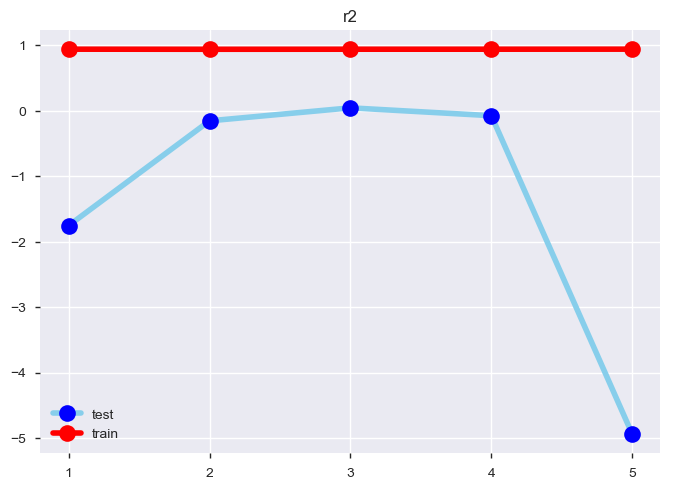

In [26]:
# Plot the cross val results
metric_to_plot = "r2"
plot_cv_results(metric_to_plot, model)


What do you think about this model?

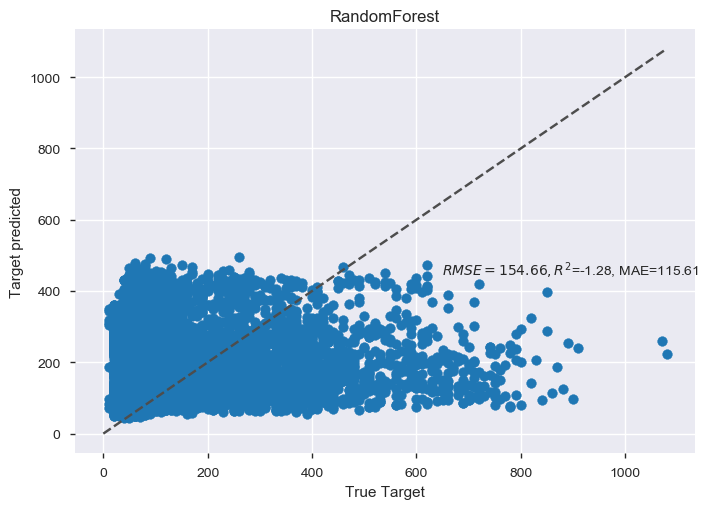

In [31]:
# Make prediction
y_pred = cross_val_predict(rfr, X, y, cv=CV, n_jobs=-1, verbose=1)
scatter_plot_result(y, y_pred, 'RandomForest')


-> `Retrain your model with another set of parameters and compare results`



## Build a second model

Often, we use a second model in order to challenge the first one...

test rmse: 96.74695119528803 - test mae: 55.76400025553919 - test r2: 0.11053893857147219


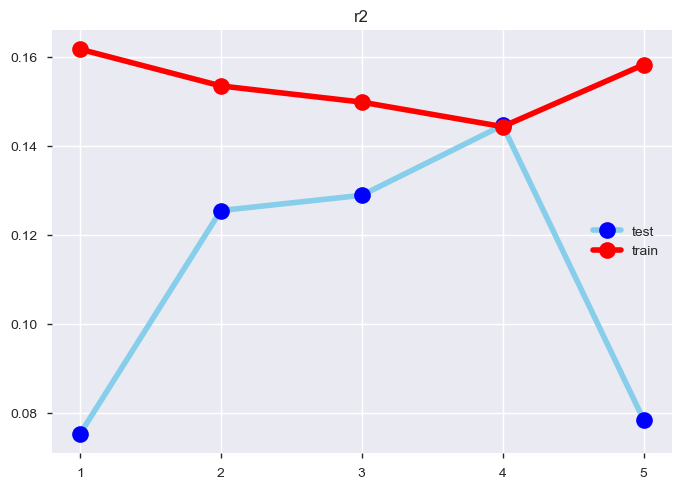

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


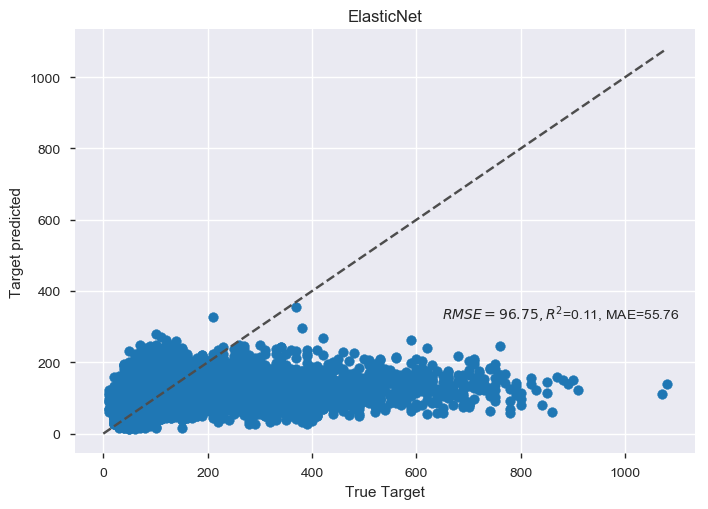

In [42]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import QuantileTransformer, quantile_transform

# Instantiate model
en = ElasticNet(random_state=0, alpha=0.5, l1_ratio=0.2)

# Train model
model = cross_validate(en, X, y, scoring=scorings, cv=CV, n_jobs=-1, return_train_score=True)
print('test rmse: {} - test mae: {} - test r2: {}'.format(*cv_eval_metrics(model)))

# Plot Cross val
metric_to_plot = "r2"
plot_cv_results(metric_to_plot, model)

# Make prediction
y_pred = cross_val_predict(en, X, y, cv=CV, n_jobs=-1, verbose=1)
scatter_plot_result(y, y_pred, 'ElasticNet')



-> `Retrain your model with another set of parameters and compare results`


# Optionnel : Understand your model

## [SHAP](https://github.com/slundberg/shap)
A unified approach to explain the output of any machine learning model.

In [ ]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x, approximate=True)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train_x)

# Utility of ML Flow

At this point you may want to draw more visualizations to compare your models :
    * performance, 
    * feature importance
    * other metrics

You understand that we will have do this process **EVERY TIME**, to compare or analyse any model or ML code. 

Also, **if your data change**, your metrics can change. It would be great to have the history of the data ATTACHED to the code's history

__*This is where Tracking with MLflow is useful*__

Same exercise in `train.py`. 

## 1 - MLflow [Tracking](https://mlflow.org/docs/latest/tracking.html)

In [45]:
from sklearn.compose import TransformedTargetRegressor

# If you wish to try on classification problem
def log_metrics_classification(y_true, y_prediction):
    report = classification_report(y_true, y_prediction, output_dict=True)
    for class_ in ['0', '1']:
        for metric in report[class_]:
            log_name = class_ + '_' + metric
            # log metrics with log_name ~ 1 line
         
        
def log_metrics_regression(cv_model):
    rmse, mae, r2 = cv_eval_metrics(cv_model)
    # log metrics here ~ 3 lines

def set_mlfow_experiment(experiment_name):
    experiment_name = 'Default' if experiment_name is None else experiment_name
    mlflow.set_experiment(experiment_name)


def run_experiment_elasticnet(df, alpha, l1_ratio, experiment_name=None):
    # set exeperiment here ~ 1 line
    set_mlfow_experiment(experiment_name)
        
    # Split features and targets
    target_column = "Appliances"
    y = df[target_column]
    X = df.drop([target_column], axis=1)

    # Nb Cross Val
    CV = 5
    
    scorings = {'mse' : make_scorer(mean_squared_error),
            "mae" : make_scorer(mean_absolute_error),
            "r2" : make_scorer(r2_score)}

    with mlflow.start_run():
        print("Running with alpha: {} - l1_ratio: {}".format(alpha, l1_ratio))

        # fit models
        lr = ElasticNet(random_state=0, alpha=alpha, l1_ratio=l1_ratio)
        model = cross_validate(lr, X, y, scoring=scorings, cv=CV, n_jobs=-1, return_train_score=True)

        prediction_test = cross_val_predict(lr, X, y, cv=CV, n_jobs=-1, verbose=1)

        # log parameters
        # Your code here ~ 2 lines

        # log plots as artifacts
        scatter_name = 'ElasticNet'
        # save scatter plot as artifact here ~ 2 lines (1 to create the file, 1 to save as artifact)
        
        # save cv_results ~ 1 line
        for metric in ['r2', 'mse', 'mae']:
            cv_result_name = metric + '_cv_result_ElasticNet'
            # plot cv result here using cv_result_name to save the plot ~ 2 line

        # log metrics 
        log_metrics_regression(model)

        # log sklearn model
        # log the sklearn model here  ~ 1 line
        

Running with alpha: 0.1 - l1_ratio: 0.1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


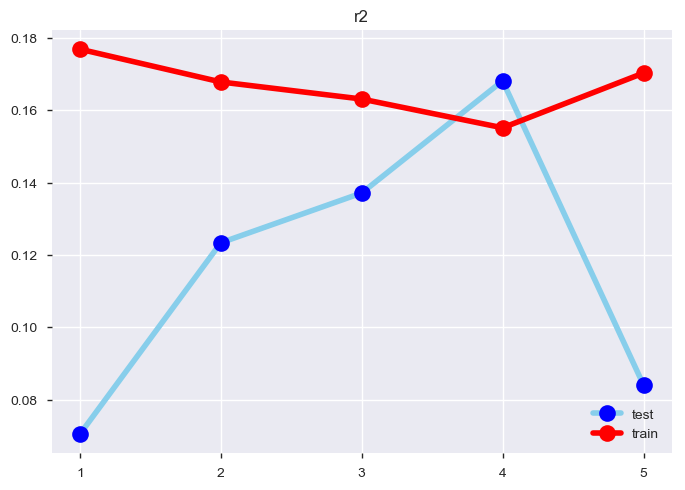

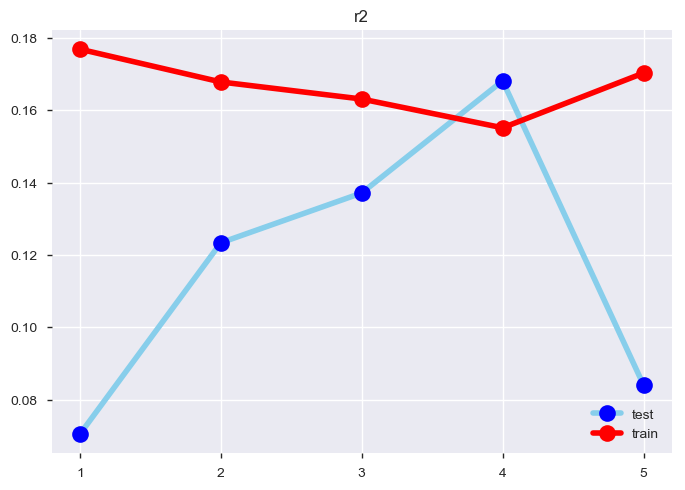

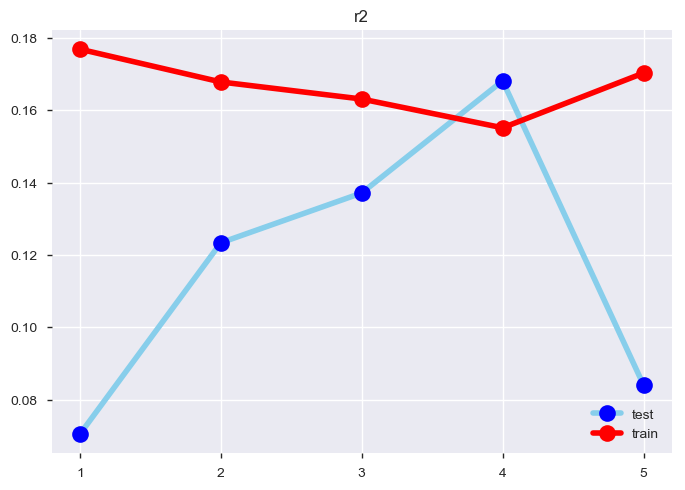

Running with alpha: 0.1 - l1_ratio: 0.30000000000000004


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


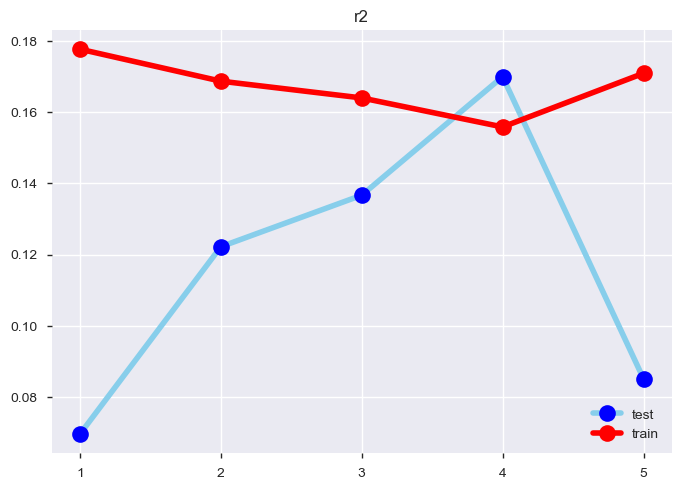

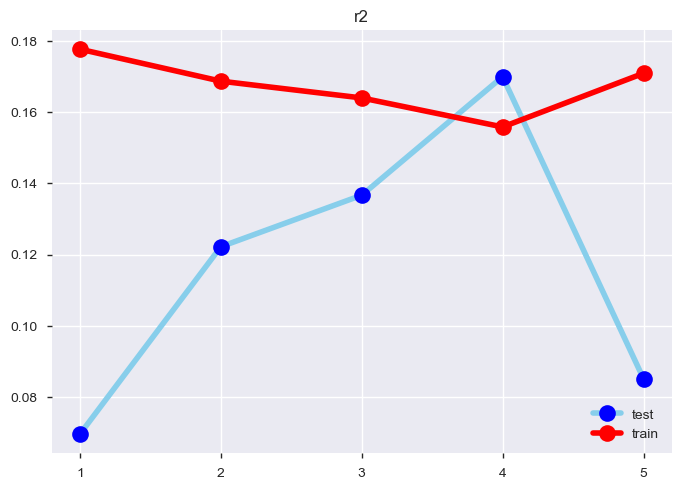

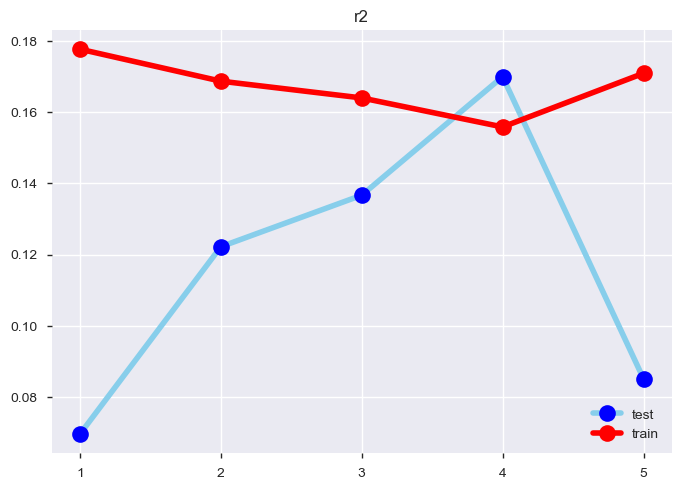

Running with alpha: 0.1 - l1_ratio: 0.5000000000000001


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


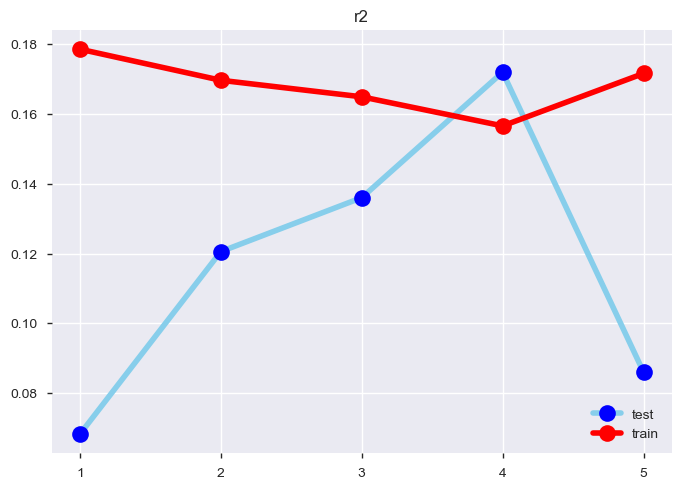

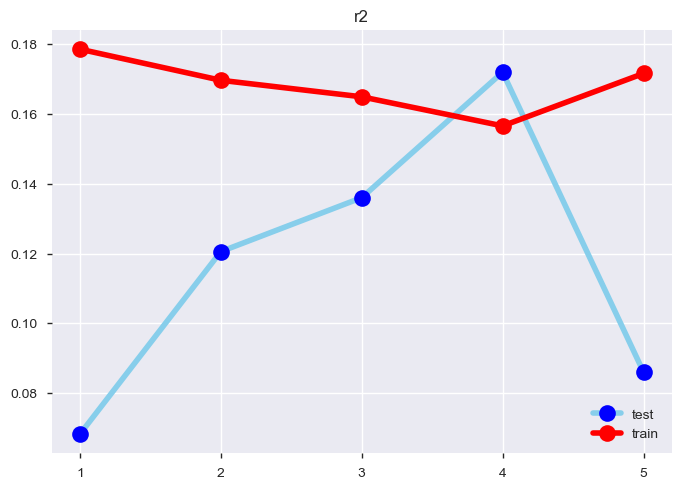

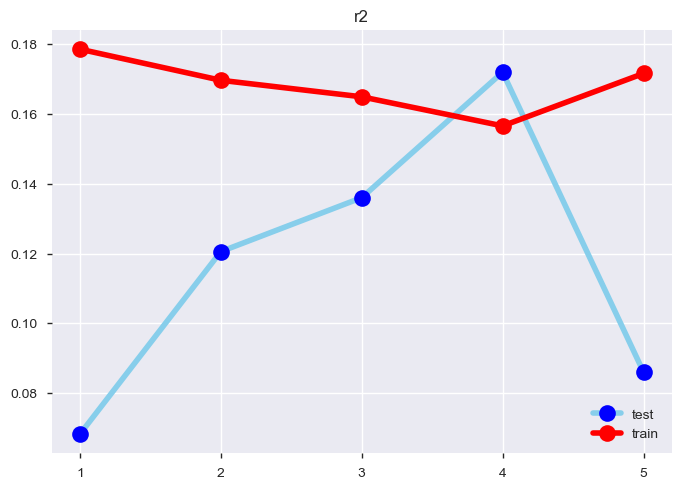

Running with alpha: 0.1 - l1_ratio: 0.7000000000000001


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


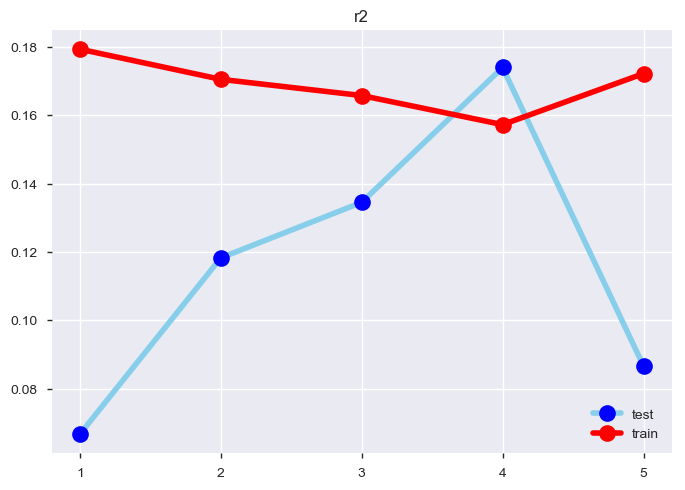

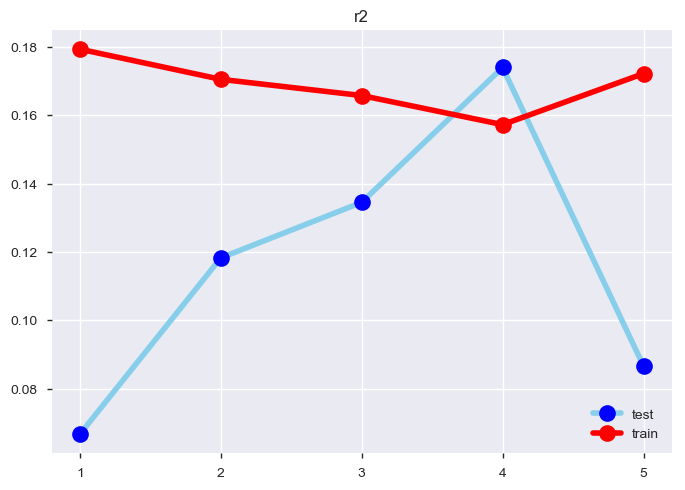

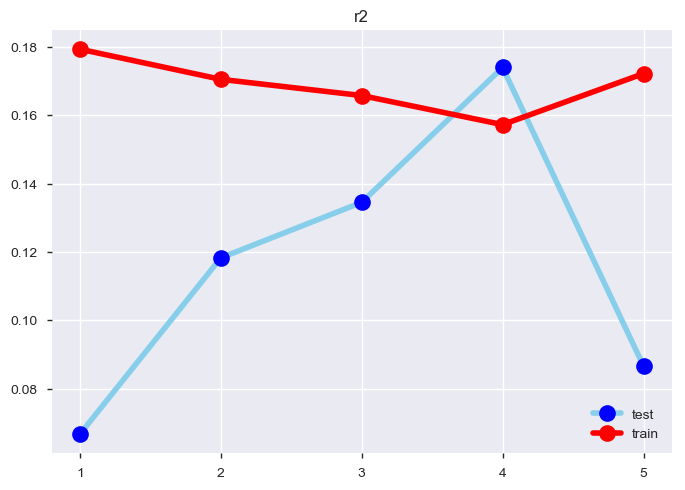

Running with alpha: 0.1 - l1_ratio: 0.9000000000000001


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


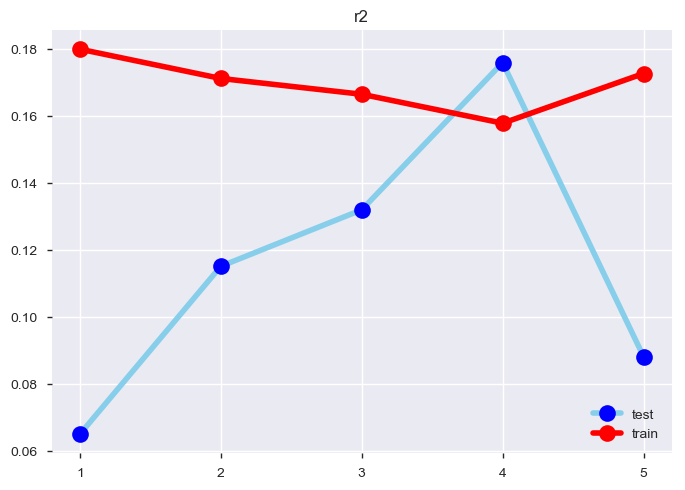

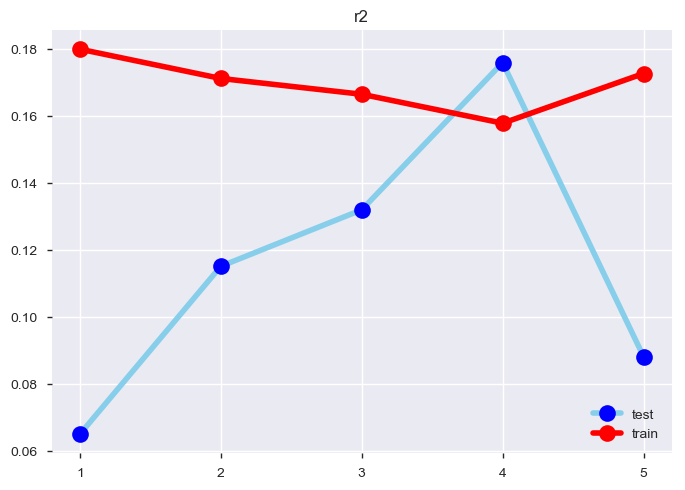

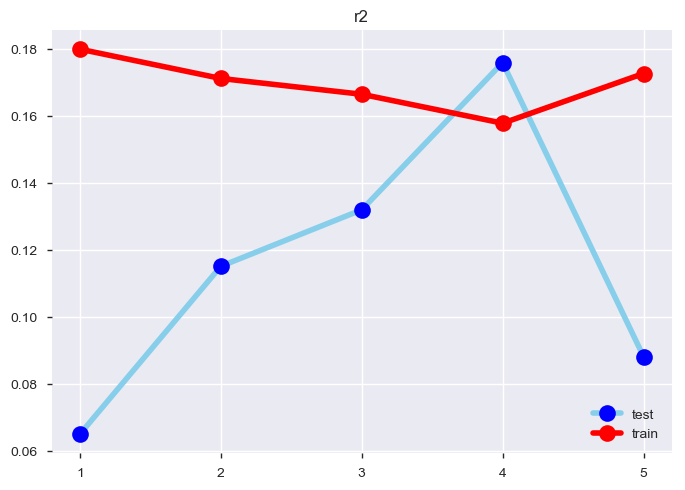

In [46]:
# play yourself with parameters
# ! both parameters have min 0 and max 1 ! 


# Remove break to see all runs
for alpha in np.arange(0.1, 1, 0.2):
    for l1_ratio in np.arange(0.1, 1, 0.2):
        run_experiment_elasticnet(df_all, alpha, l1_ratio)
    break
    

## 2 - MLflow [Projects](https://mlflow.org/docs/latest/projects.html)

**Now we will "package" our project as an MLflow project:**
* MLflow Projects are just a convention for organizing and describing your code
* Each project is simply a directory of files, or a Git repository, containing your code
* MLflow can run some projects based on a convention for placing files in this directory but you can describe your project in more detail by adding a `MLproject file, which is a YAML formatted text` file

**We will make our `MLproject file` and define:**
* Name
* Entry point (you can define several entry point : etl -> train -> test, but here we just have the main entry point)
* (Environment is optional, see documentation for more information)


-> open it: [MLproject file](./MLproject)


**Once you finished your MLproject file**
The following command runs your project by read your MLproject file on your local system.

```bash 
~$ mlflow run .
```



**What if you want to change your code, push it on a remote repo and test it with its git hash ?**
```bash 
~$ mlflow run git@github.com:thomasOpenvalue/workshop-mlflow.git --version=84295be...
```

**more details**:
```bash
~$ mlflow run --help
```

## 3 - MLflow [Models](https://mlflow.org/docs/latest/models.html)

During your runs, you saved/logged your models. Each model is attached to a run and you can see it in your MLflow UI by clicking on a run.

You can re-use a given model or serve it. MLflow allows you to use a lot of model type like sagemaker models, sklearn models, keras models.
Also you can use the Model API as follow.

You we'll need to choose a **path** (if you used mlflow.save_model -> the same used path. If you used mlflow.log_model -> the name you gave for the log) and the **run_id** (choose a run in your UI)

for more details : [MLflow Model API](https://mlflow.org/docs/latest/models.html#model-api)

In [49]:
import mlflow.sklearn

sk_model = mlflow.sklearn.load_model(path="elastic_net", run_id="2cb....")

pred_test = sk_model.predict(test_x)

print('rmse: {} - mae: {} - r2: {}'.format(*eval_metrics(test_y, pred_test)))

/Users/fontaine/anaconda3/envs/workshop-mlflow/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator ElasticNet from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
